In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))


In [43]:
from dotenv import load_dotenv
import pandas as pd
import numpy as np

import sql_queries as sq

# Database
from db import PostgresDB
from schemas import Proband
from cohorts import Cohort

# Clustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation

# Plotting matrix
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from plotting import plot_endpoints_for_clusters

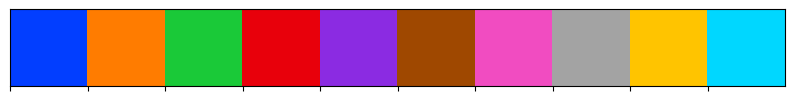

In [44]:
palette = sns.color_palette("bright", 10)
sns.palplot(palette)

In [45]:
load_dotenv()


True

In [46]:
db = PostgresDB(
    db_name=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    user=os.getenv("DB_USER"),
)


Connected to database


In [47]:
cohort = Cohort(db=db, name="test_cohort")


In [48]:
cohort.get_sepsis_cohort(limit=None, min_age=18, max_age=65, gender="F")


### Age distribution


In [49]:
ages = db.execute_query(
    "SELECT age FROM mimiciv_derived.age WHERE hadm_id = ANY(%s)", (cohort.hadm_ids,)
)
ages = [i[0] for i in ages]


/var/folders/0x/6dppp0gd4kb1c3snslkflksr0000gn/T/ipykernel_92789/860233856.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ages, kde=False, bins=47)


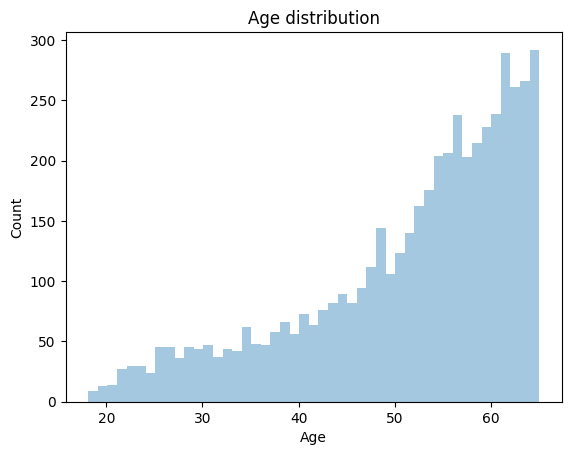

In [50]:
# plot age distribution
sns.distplot(ages, kde=False, bins=47)
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


### Labevents


In [51]:
labevents = db.execute_query(
    """
SELECT 
    le.itemid, le.subject_id, le.hadm_id, le.valuenum, le.valueuom,
    ls.mean_value, ls.std_dev, li.label
FROM 
    mimiciv_hosp.labevents le, labevent_statistics ls, mimiciv_hosp.d_labitems li
WHERE 
    le.hadm_id = ANY( %s ) 
    AND le.itemid = ls.itemid
    AND le.itemid = li.itemid
""",
    (cohort.hadm_ids,),
)


In [52]:
columns = [
    "itemid",
    "subject_id",
    "hadm_id",
    "valuenum",
    "valueuom",
    "mean_value",
    "std_dev",
    "label",
]
labevents_df = pd.DataFrame(labevents, columns=columns)


In [56]:
labevents_df.head()

,itemid,subject_id,hadm_id,valuenum,valueuom,mean_value,std_dev,label
0,50802,10002013,23581541,0.00,mEq/L,-0.364103,6.366767,Base Excess
1,50804,10002013,23581541,27.00,mEq/L,25.869978,6.354654,Calculated Total CO2
2,50806,10002013,23581541,101.00,mEq/L,104.102550,6.216901,"Chloride, Whole Blood"
3,50808,10002013,23581541,1.16,mmol/L,1.122398,0.383257,Free Calcium
4,50809,10002013,23581541,332.00,mg/dL,147.531995,2785.936393,Glucose


In [53]:
print(f"Total count of labevents: {len(labevents_df)}")
print(f"Total count of unique labevent measurements: {len(labevents_df['itemid'].unique())}")

Total count of labevents: 3232039
Total count of unique labevent measurements: 552


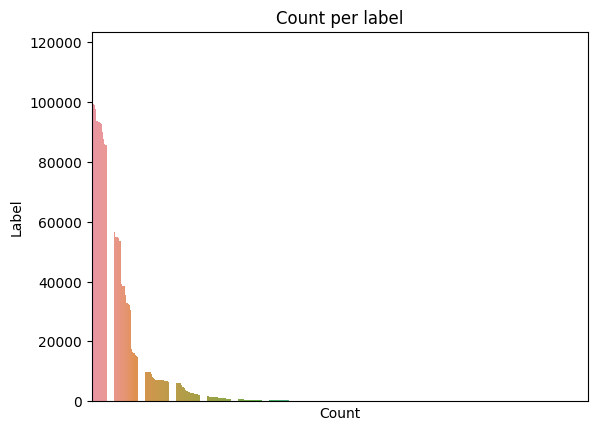

In [54]:
# plot count per labels
sns.countplot(
    x="label", data=labevents_df, order=labevents_df["label"].value_counts().index
)
plt.title("Count per label")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.xlabel("Count")
plt.ylabel("Label")
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


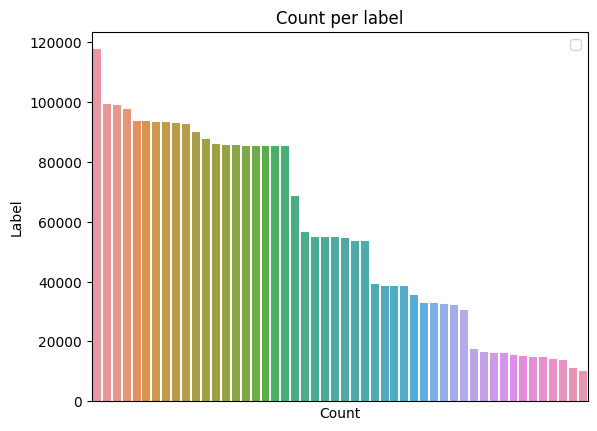

In [55]:
# plot the 50 most common labevents by label
sns.countplot(
    x="label",
    data=labevents_df,
    order=labevents_df["label"].value_counts().iloc[:50].index,
)
plt.title("Count per label")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.xlabel("Count")
plt.ylabel("Label")
plt.legend(loc="upper right")
plt.show()

In [64]:
labevents_df["label"].value_counts().iloc[:50]

Glucose                            117407
Sodium                              99213
Potassium                           98932
Chloride                            97496
Bicarbonate                         93617
Creatinine                          93487
Anion Gap                           93314
Urea Nitrogen                       93218
Hemoglobin                          92733
Hematocrit                          92593
Magnesium                           89759
Platelet Count                      87617
Phosphate                           85800
White Blood Cells                   85494
Calcium, Total                      85386
MCHC                                85320
Red Blood Cells                     85312
MCH                                 85311
MCV                                 85311
RDW                                 85311
pH                                  68597
PTT                                 56481
pO2                                 54694
Base Excess                       

### Diagnoses

In [65]:
diagnoses = db.execute_query(
    """
SELECT * FROM mimiciv_hosp.diagnoses_icd WHERE hadm_id = ANY( %s );
""",
    (cohort.hadm_ids,),
)


In [66]:
diagnoses[:10]

[(10002013, 23581541, 1, '41401  ', 9),
 (10002013, 23581541, 2, '42832  ', 9),
 (10002013, 23581541, 3, '5180   ', 9),
 (10002013, 23581541, 4, '4280   ', 9),
 (10002013, 23581541, 5, '4139   ', 9),
 (10002013, 23581541, 6, '4400   ', 9),
 (10002013, 23581541, 7, '4019   ', 9),
 (10002013, 23581541, 8, '34690  ', 9),
 (10002013, 23581541, 9, '71590  ', 9),
 (10002013, 23581541, 10, '496    ', 9)]